In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Adding Project Directory to System

The module `utils` is not in a location where Python can find it. We add the project directory in Google Drive to the system's path.

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/LLM/Embeddings')

In [ ]:
!pip install cohere
!pip install -q -U "google-genai>=1.0.0"

In [3]:
import os
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cohere
from google import genai
from google.colab import userdata

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from utils import (
    group_by,
    create_subset,
    cohere_embeddings,
    gemini_embeddings,
    compress_by_pca,
    create_embed_heatmap,
    EmbedSimilarity,
)

# Cohere and Google API Keys

This project utilizes the official SDKs from [Cohere](https://docs.cohere.com/reference/about) and [Google](https://github.com/googleapis/python-genai?tab=readme-ov-file) to interact with their respective embedding models.

To use Cohere's models, we will first need to create a free account to generate an API key. We will enter and store this key in an environment variable, a standard practice for securely managing configuration details and credentials outside the main codebase.

For Google's models, the API key is generated from the [Google AI Studio](https://aistudio.google.com/app/apikey). We can seamlessly integrate it into Google Colab. The recommended approach is to save this key in the Secrets Manager (accessible via the 🔑 icon) with the name GOOGLE_API_KEY.

In [ ]:
if not os.getenv("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API key: ")

co = cohere.ClientV2(os.getenv("COHERE_API_KEY"))
go = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

Enter your Cohere API key: ··········


# Airline Travel Information System

The Airline Travel Information System (ATIS) dataset is a widely recognized benchmark in the field of Natural Language Understanding (NLU), specifically tailored for the task of intent classification.It comprises a collection of user queries in the form of textual messages related to airline travel. Each message is annotated with a specific intent, representing the user's goal, such as inquiring about flights, fares, or ground transportation. A common configuration of this dataset, as found on [Kaggle](https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem), is partitioned into a training set of $4834$ samples and a testing set of $800$ samples. In total, $8$ classes are maintained, and class distribution is not balanced.



In [5]:
# read the dataset into a DataFrame by intent-query column names
data_dir = "/content/drive/MyDrive/LLM/Embeddings/ATIS/atis_intents_train.csv"
df = pd.read_csv(data_dir, names=['intent','query'])

# grouping data entries by classes
size = len(df)
df_count = group_by(df, size)

display(df)
display(df_count)

,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...
...,...,...
4829,atis_airfare,what is the airfare for flights from denver t...
4830,atis_flight,do you have any flights from denver to baltim...
4831,atis_airline,which airlines fly into and out of denver
4832,atis_flight,does continental fly from boston to san franc...


,intent,count,percentage
0,atis_abbreviation,147,3.040960
1,atis_aircraft,81,1.675631
2,atis_airfare,423,8.750517
3,atis_airline,157,3.247828
4,atis_flight,3666,75.837815
5,atis_flight_time,54,1.117087
6,atis_ground_service,255,5.275134
7,atis_quantity,51,1.055027


Ar first, we choose $3$ class names. Then, we randomly choose $10\%$ of entire dataset to create an its subset. This subset is filtered by the class names that we choose before; only the samples with those classes are preserved. At the end, $91$ number of samples are maintained with the following classes: ***\[Airfare, Airline, Ground Service\]***

In [6]:
class_names = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df_subset = create_subset(df, 0.1, class_names, True)

df_subset_count = group_by(df_subset, size)
display(df_subset_count)

,intent,count,percentage
0,atis_airfare,54,1.117087
1,atis_airline,15,0.310302
2,atis_ground_service,22,0.455110


# Embeddings Generation

Our main purpose here is to generate the embeddings of customer queries represented in text messages. To accomplish this, we create a request and send it to execute Cohere's embedding model in the cloud. Let's list the template pipeline:

1. We instantiate a client object by `cohere.ClientV2()` by our API key. ***(Local)***

2. Then, we invoke `co.embed()` function to be able to access  <ins>*embed-v4.0* model</ins>. ***(Local)***

3. Inside the SDK, the given arguments are serialized into JSON and an HTTP POST request is created to be sent to https://api.cohere.com/v2/embed. ***(Network)***

4. Cohere’s servers run the requested model, generate the embedding vectors, and return a JSON object. ***(Cloud)***

5. SDK deserialises JSON into a response of python object so you can access by response.embeddings and response.id. ***(Local)***

To summarize, there is a Python-SDK wrapper around Cohere's REST API. Using this SDK, we send an HTTP request to this API. Upon this request, Cohere's embedding model is executed on the cloud. By a similar principle, we also produce gemini embeddings as an alternative.

In [7]:
queries = df_subset['query'].tolist()

# a list of lists (91, 1536)
co_embeddings = cohere_embeddings(co, queries, input_type="classification")
ge_embeddings = gemini_embeddings(go, queries, task_type="CLASSIFICATION")

df_subset["co_embeds"] = co_embeddings
df_subset["ge_embeds"] = ge_embeddings

# PCA Compression and HeatMap

In our subset, there are $91$ data samples, each comprised of $1536$ features in its embedding vector. By ***Principal Component Analysis (PCA)***, these embeddings are compressed into $5$ dimensional sub-space. Our main purpose here is to visualize these embeddings by heat-map, nevertheless, to be able to investigate them in an easier way, we need this compression, which simplifies the interpretation of these embeddings.

Among these $91$ samples, the ones in the range of $10$ and $20$ are selected for visualization.

- Samples $\{0, 1, 6, 8\} →$ ***Atis Airline***
- Samples $\{2, 3, 4, 9\} →$ ***Atis Airfare***
- Samples $\{5, 7\} →$ ***Atis Ground Service***

When we investigate their heat-maps, the ones with the same class are similar to each other. Especially, first two entries are the most descriptive ones.

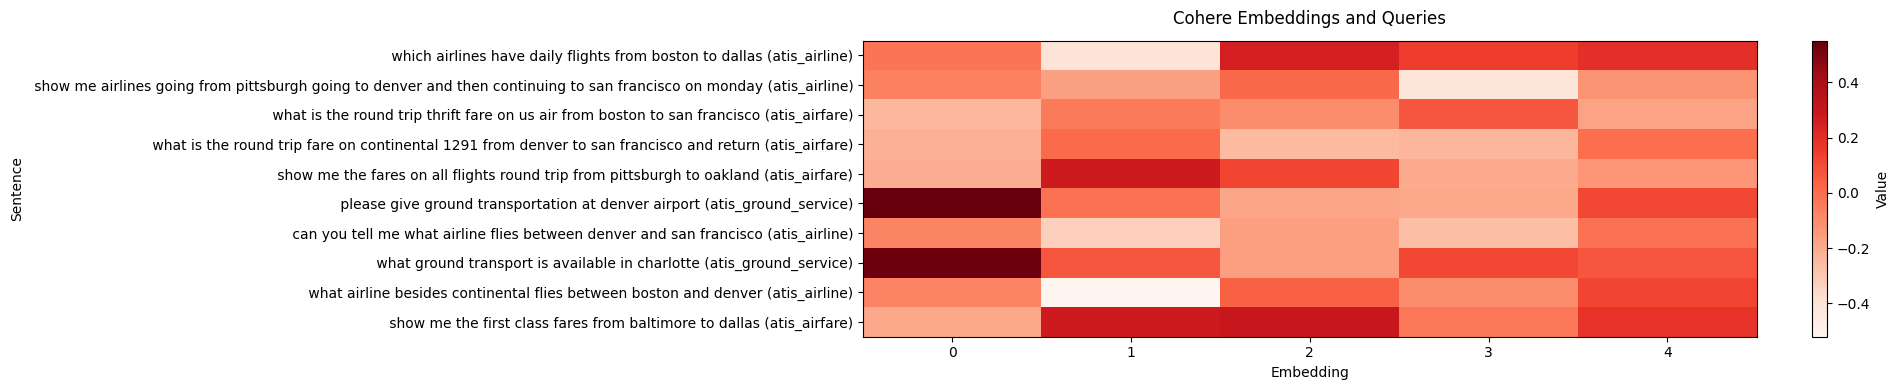

In [8]:
co_pca_embeds = create_embed_heatmap(
    df_subset,
    pca_dim=5,
    embed_type="co_embeds",
    sample_range=(10, 20)
)

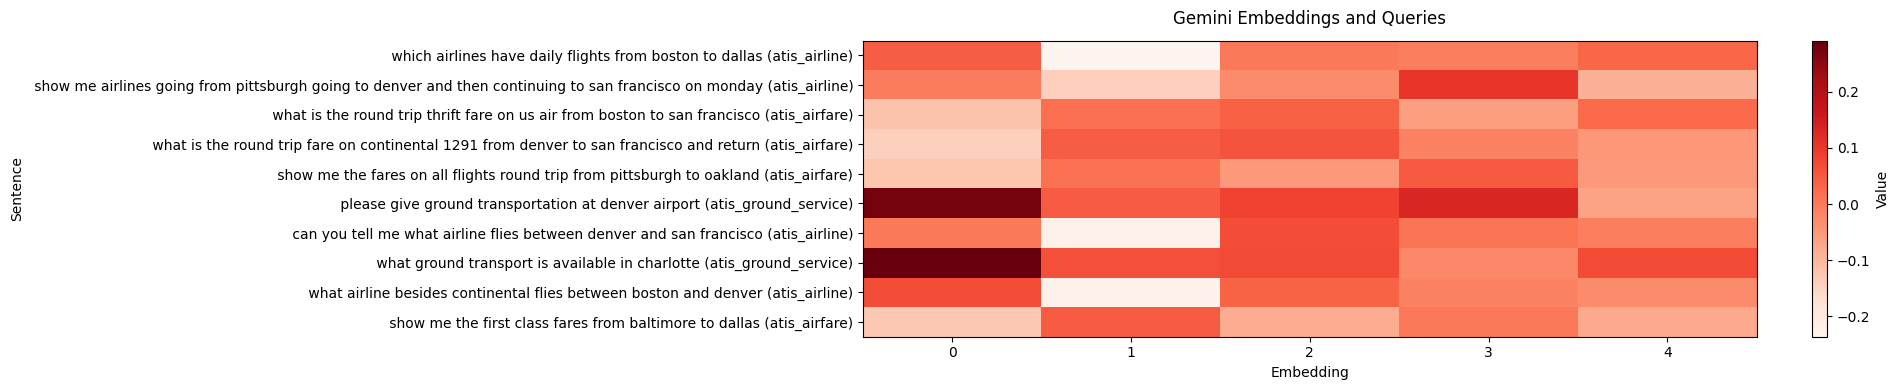

In [9]:
ge_pca_embeds = create_embed_heatmap(
    df_subset,
    pca_dim=5,
    embed_type="ge_embeds",
    sample_range=(10, 20)
)

# Analyze Similarity by Cohere Embeds

The samples $\{0, 1, 6, 8\}$ have very similar content of queries, so all of them are classified under <ins>***atis airline***</ins>. In that case, their Cohere embeddings should be similar to one another.

When we interrogate their similarity in the code below, we observe that samples $8$ and $6$ are quite similar to sample $1$ so they are in its top $3$. Nevertheless, sample $0$ is considered to be distant. This means that the success rate of embedding quality is $2/3$.

In [11]:
simiAnalyzer = EmbedSimilarity(co_pca_embeds)

target_embed = 1
query_embeds = [0, 8, 6]
search_frame = 3

results, top_n = simiAnalyzer.get_proximity(target_embed, query_embeds, search_frame)

print("\nMatched queries: ", results)
print(f"Top {search_frame} most similar samples", top_n)

WRONG, 0 is distant from 1
CORRECT, 8 is highly similar to 1
CORRECT, 6 is highly similar to 1

Matched queries:  [8, 6]
Top 3 most similar samples [6 3 8]


# Analyze Similarity by Gemini Embeds

The samples $\{0, 1, 6, 8\}$ have very similar content of queries, so all of them are classified under <ins>***atis airline***</ins>. In that case, their Gemini embeddings should be similar to one another.

When we interrogate their similarity in the code below, we observe that all samples $\{8, 6, 0\}$ are quite similar to sample $1$ so they are in its top $3$. This means that the success rate of embedding quality is $3/3$.

In [14]:
simiAnalyzer = EmbedSimilarity(ge_pca_embeds)

target_embed = 1
query_embeds = [0, 8, 6]
search_frame = 3

results, top_n = simiAnalyzer.get_proximity(target_embed, query_embeds, search_frame)

print("\nMatched queries: ", results)
print(f"Top {search_frame} most similar samples", top_n)

CORRECT, 0 is highly similar to 1
CORRECT, 8 is highly similar to 1
CORRECT, 6 is highly similar to 1

Matched queries:  [0, 8, 6]
Top 3 most similar samples [6 8 0]
